In [8]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0.5)

In [10]:
llm.invoke("Write a Python function that computes the Fibonacci sequence up to n.").content

'<think>\nOkay, I need to write a Python function that computes the Fibonacci sequence up to n. Hmm, let me think about how the Fibonacci sequence works. So, the sequence starts with 0 and 1, right? And each subsequent number is the sum of the two preceding ones. So, like 0, 1, 1, 2, 3, 5, and so on.\n\nWait, sometimes people start with 1 and 1 instead of 0 and 1. I should clarify that. Maybe the function should start with 0 and 1 as the first two numbers. That seems more standard in programming contexts.\n\nSo, the function needs to take an integer n as input, which represents the number of terms in the sequence. For example, if n is 5, the output should be [0, 1, 1, 2, 3]. Or maybe it\'s the nth term? Wait, the question says up to n, so I think it\'s the number of terms.\n\nLet me make sure. If n is 1, the sequence is just [0]. If n is 2, it\'s [0, 1]. If n is 3, [0, 1, 1], and so on. So, yeah, the function should generate the first n Fibonacci numbers.\n\nHow do I approach this? Wel

In [11]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [12]:
generator_llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0.5)
evaluator_llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0.5)
optimizer_llm = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0.5)

In [13]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [14]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [15]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [16]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [17]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [18]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [19]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

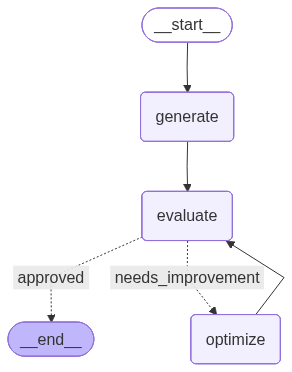

In [20]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [21]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [22]:
result

{'topic': 'srhberhb',
 'tweet': '<think>\nOkay, so I need to come up with a short, funny tweet about "srhberhb". First, I should figure out what "srhberhb" is. It looks like a typo or a random string of letters. Maybe it\'s supposed to be "strawberry"? That makes sense because "strawberry" is a common word that people might typo. \n\nSo, if I go with that, I can make a joke about the typo. People often make fun of typos on social media, so that\'s relatable. Maybe something about how the typo is trying to be something else. Like, "srhberhb" is "strawberry" but it\'s acting like it\'s something more complicated. \n\nI could use a metaphor, like comparing the typo to something else. Maybe something like "when you think you\'re a smoothie but you\'re just a typo of a strawberry." That plays on the idea of thinking you\'re more complex or put together than you actually are. \n\nI should keep it simple and under 280 characters. Let me check: "srhberhb: when you think you\'re a smoothie but 